In [1]:
import os
import math
import dill
from itertools import permutations, product

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.mixed_linear_model import MixedLM
import pingouin as pg

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u


plt.rcParams['pdf.fonttype']=42

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# load session
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
mouse = 'SparseKO_05'
d = sparse_sessions[mouse][-1]
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']


pkldir = os.path.join('C://Users/esay/data/Stx3/YMazeSessPkls/', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)


# Place cell sequences

In [3]:
trial_masks = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}
channel_0_mask = sess.trial_info['block_number']%2==0
left_mask = sess.trial_info['LR']==-1


trial_masks['channel_0_left'] = channel_0_mask*left_mask
trial_masks['channel_0_right'] = channel_0_mask*~left_mask
trial_masks['channel_1_left'] = ~channel_0_mask*left_mask
trial_masks['channel_1_right'] = ~channel_0_mask*~left_mask


In [4]:
# extract place cell trial matrices for each condition
pc_mats = {'channel_0_left': None,
           'channel_0_right': None,
           'channel_1_left': None,
           'channel_1_right': None}

pc_mats['channel_0_left'] = sess.trial_matrices['channel_0_F_dff'][trial_masks['channel_0_left'],:,:][:,:,sess.place_cell_info['channel_0_F_dff']['left']['masks']]
pc_mats['channel_0_right'] = sess.trial_matrices['channel_0_F_dff'][trial_masks['channel_0_right'],:,:][:,:,sess.place_cell_info['channel_0_F_dff']['right']['masks']]
pc_mats['channel_1_left'] = sess.trial_matrices['channel_1_F_dff'][trial_masks['channel_1_left'],:,:][:,:,sess.place_cell_info['channel_1_F_dff']['left']['masks']]
pc_mats['channel_1_right'] = sess.trial_matrices['channel_1_F_dff'][trial_masks['channel_1_right'],:,:][:,:,sess.place_cell_info['channel_1_F_dff']['right']['masks']]


In [5]:
pc_mats['channel_0_left'].shape

(43, 30, 206)

In [6]:
# make odd and even trial averages
argsorts = {'channel_0_left': None,
           'channel_0_right': None,
           'channel_1_left': None,
           'channel_1_right': None}

for k, tmat in pc_mats.items():
    argsorts[k] = np.argsort(np.argmax(np.nanmean(tmat[::2,:,:], axis=0),axis=0))



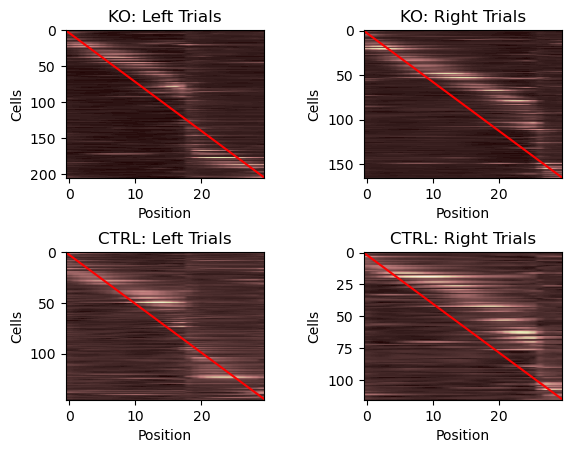

In [7]:
# plot even, sorted by odd

fig, ax = plt.subplots(2,2)

tmat = pc_mats['channel_0_left']
trial_mean = np.nanmean(tmat[1::2,:,:], axis=0)[:, argsorts['channel_0_left']]
ax[0,0].imshow(trial_mean.T, cmap='pink', aspect='auto')
ax[0,0].plot([-.5,29.5], [0, tmat.shape[-1]-1], color='red')
ax[0,0].set_title('KO: Left Trials')

tmat = pc_mats['channel_0_right']
trial_mean = np.nanmean(tmat[1::2,:,:], axis=0)[:, argsorts['channel_0_right']]
ax[0,1].imshow(trial_mean.T, cmap='pink', aspect='auto')
ax[0,1].plot([-.5,29.5], [0, tmat.shape[-1]-1], color='red')
ax[0,1].set_title('KO: Right Trials')

tmat = pc_mats['channel_1_left']
trial_mean = np.nanmean(tmat[1::2,:,:], axis=0)[:, argsorts['channel_1_left']]
ax[1,0].imshow(trial_mean.T, cmap='pink', aspect='auto')
ax[1,0].plot([-.5,29.5], [0, tmat.shape[-1]-1], color='red')
ax[1,0].set_title('CTRL: Left Trials')

tmat = pc_mats['channel_1_right']
trial_mean = np.nanmean(tmat[1::2,:,:], axis=0)[:, argsorts['channel_1_right']]
ax[1,1].imshow(trial_mean.T, cmap='pink', aspect='auto')
ax[1,1].plot([-.5,29.5], [0, tmat.shape[-1]-1], color='red')
ax[1,1].set_title('CTRL: Right Trials')

fig.subplots_adjust(hspace=.5, wspace=.5)

for r, c in product(range(2),range(2)):
    ax[r,c].set_ylabel('Cells')
    ax[r,c].set_xlabel('Position')

# Reward Cells

In [8]:
def get_smooth_hist(max1, max2,bins = np.arange(0,30)):
    hist, xedges, yedges = np.histogram2d(max1,max2, bins = [bins, bins], density = True)
    hist_sm = sp.ndimage.gaussian_filter(hist, (1,1))
    hist_sm /= hist_sm.ravel().sum()
    return hist_sm

rz_early = (np.argwhere(sess.trial_matrices['bin_edges'][:-1]>=sess.rzone_early['tfront'])[0], np.argwhere(sess.rzone_early['tback']<=sess.trial_matrices['bin_edges'][1:])[0] )
rz_late = (np.argwhere(sess.trial_matrices['bin_edges'][:-1]>=sess.rzone_late['tfront'])[0], 29 )

2.534695764166178e-09 0.026502716861205828


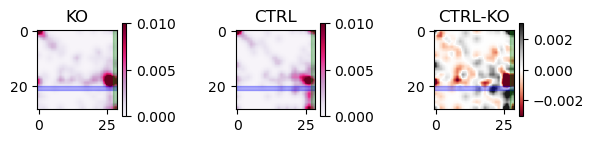

In [9]:
channel_0_pcs = sess.place_cell_info['channel_0_F_dff']['left']['masks'] | sess.place_cell_info['channel_0_F_dff']['right']['masks']

left_trial_mean = np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['channel_0_left'],:,:][:,:,channel_0_pcs],axis=0)
right_trial_mean = np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['channel_0_right'],:,:][:,:,channel_0_pcs],axis=0)

channel_0_hist_sm = get_smooth_hist(np.argmax(left_trial_mean,axis=0), np.argmax(right_trial_mean,axis=0))


channel_1_pcs = sess.place_cell_info['channel_1_F_dff']['left']['masks'] | sess.place_cell_info['channel_1_F_dff']['right']['masks']

left_trial_mean = np.nanmean(sess.trial_matrices['channel_1_F_dff'][trial_masks['channel_1_left'],:,:][:,:,channel_1_pcs],axis=0)
right_trial_mean = np.nanmean(sess.trial_matrices['channel_1_F_dff'][trial_masks['channel_1_right'],:,:][:,:,channel_1_pcs],axis=0)

channel_1_hist_sm = get_smooth_hist(np.argmax(left_trial_mean,axis=0), np.argmax(right_trial_mean,axis=0))



fig,ax = plt.subplots(1,3)
print(np.amin(channel_0_hist_sm), np.amax(channel_0_hist_sm))
h=ax[0].imshow(channel_0_hist_sm, cmap='PuRd', vmin=0, vmax=.01)
ax[0].set_title('KO')
fig.colorbar(h,shrink=.25)
h=ax[1].imshow(channel_1_hist_sm, cmap='PuRd', vmin=0, vmax=.01)
ax[1].set_title('CTRL')
fig.colorbar(h,shrink=.25)
h=ax[2].imshow(channel_1_hist_sm-channel_0_hist_sm, cmap='RdGy', vmin=-.003, vmax=.003)
ax[2].set_title('CTRL-KO')
fig.colorbar(h,shrink=.25)

for a in ax:
    a.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
    a.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')

fig.subplots_adjust(wspace=1)